In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
class BERT(nn.Module):
    def __init__(self, num_classes):
        super(BERT, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = nn.Dropout(0.3)
        self.out  = nn.Linear(self.bert_model.config.hidden_size, num_classes)
        #self.out  = nn.Linear(768, num_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert_model(
          input_ids=input_ids,
          attention_mask=attention_mask, 
          return_dict=False
        )
        output_dropout = self.dropout(pooled_output)
        output = self.out(output_dropout)
        return output
    

In [5]:
from torch.utils.data import Dataset
import re
import chardet # an ML model, It uses machine learning to detect the encoding of a file
import requests 

#Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index] # this text is a URL 
        target = self.targets[index]
        
        url_to_text = self.url_to_content(text)
        non_ASCII_removed_text = self.remove_non_ascii(url_to_text)
        multiple_spaces_removed_text = self.remove_multiple_spaces(non_ASCII_removed_text)
        numbers_removed_text = self.number_removal(multiple_spaces_removed_text)
        
        encoding  = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
#         return {
#             'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
#             'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
#             'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
#             'targets': torch.tensor(self.targets[index], dtype=torch.float)
            
#         }
        return {
           'text': text,
           'input_ids': encoding['input_ids'].flatten(),
           'attention_mask': encoding['attention_mask'].flatten(),
           'targets': torch.tensor(target, dtype=torch.long)
        }
    
    def number_removal(self, text):
        # Remove numbers using regular expression
        return re.sub(r'\d+', '', text)
    
    def remove_non_ascii(self, text):
        #Remove non-ASCII characters from the given text using a regular expression.
        cleaned_text = re.sub(r'[^\x00-\x7F]+', '', text)
        return cleaned_text
    
    def remove_multiple_spaces(self, text):
        multiple_spaces_removed_text = " ".join(text.split()) 
        return multiple_spaces_removed_text
    
    def url_to_content(self, url):
        try:    
            response = requests.get(url)
            content = response.content
            encoding = chardet.detect(content)

            if encoding['encoding'] == "ISO-8859-1":
               decoded_content = content.decode("iso-8859-1")
            elif encoding['encoding'] == "GB2312":
                decoded_content = content.decode("GB2312")
            else:
                decoded_content = content.decode("utf-8")
                
            return decoded_content
        
        except Exception as e:
            print(url)
            decoded_content = content.decode("utf-8")
            cleaned_content = remove_non_ascii(decoded_content)
            return cleaned_content
    

        

In [6]:
import pandas as pd

df = pd.read_csv("../data/data_files.csv", encoding= 'unicode_escape') # read the data


In [7]:
def reduce_dataset(df):
    labels = df["Name"].unique()
    new_df = pd.DataFrame()
    
    length = df[df["Name"] == "GAP"].shape[0]
    
    for label in labels:
        new_df = pd.concat([new_df, df[df["Name"] == label].sample(length)], ignore_index=True)
    
    return new_df

In [8]:
reduced_df = reduce_dataset(df)

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
# Fit and transform the target labels
reduced_df["labels"] = label_encoder.fit_transform(reduced_df["Name"])

In [10]:
label_encoder.classes_

array(['GAP', 'GO', 'JAVA', 'JAVASCRIPT', 'PHP', 'PYTHON', 'RUBY',
       'TYPESCRIPT'], dtype=object)

In [11]:
reduced_df.drop(['Name'], inplace=True, axis=1)

In [12]:
reduced_df.columns

Index(['URL', 'labels'], dtype='object')

In [13]:
import numpy as np

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [14]:
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(reduced_df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [15]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
EPOCHS = 2
shuffle = True
BATCH_SIZE = 16
MAX_LEN = 216

In [17]:
from torch.utils.data import DataLoader

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = CustomDataset(
      texts=df["URL"].to_numpy(),
      targets=df["labels"].to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
    )

    return DataLoader(
      ds,
      batch_size=batch_size,
      shuffle=shuffle
#       num_workers=4 # In normal pyton code this line works fine but in jupyter not working
    )

In [18]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [19]:
#Hyperparameters
# input_size = len(train_data_loader) # give the number of features here
num_classes = len(label_encoder.classes_) # give the number of classes here
learning_rate = 2e-5


In [20]:
# Initialise network
model = BERT(num_classes=num_classes).to(device)

In [21]:
# Loss and optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
def train_epoch(model, data_loader, loss_fn, optimizer, 
                  device, scheduler, n_examples):
    
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)
     
        

In [23]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
%%time

from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      train_data_loader,    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn, 
      device, 
      len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
     

Epoch 1/2
----------
Train loss 0.11295463664565342 accuracy 0.9661971830985916
Val   loss 0.0007961480417025258 accuracy 1.0

Epoch 2/2
----------
Train loss 0.0009440988950791076 accuracy 1.0
Val   loss 0.0005777018728999878 accuracy 1.0

CPU times: total: 10min 15s
Wall time: 1h 25min 41s


In [32]:
history

defaultdict(list,
            {'train_acc': [tensor(0.9662, device='cuda:0', dtype=torch.float64),
              tensor(1., device='cuda:0', dtype=torch.float64)],
             'train_loss': [0.11295463664565342, 0.0009440988950791076],
             'val_acc': [tensor(1., device='cuda:0', dtype=torch.float64),
              tensor(1., device='cuda:0', dtype=torch.float64)],
             'val_loss': [0.0007961480417025258, 0.0005777018728999878]})

In [45]:
# Convert tensors in the history object to CPU
history_cpu = defaultdict(list)
for key, value_list in history.items():
    for value in value_list:
        if isinstance(value, torch.Tensor):
            history_cpu[key].append(value.cpu())
        else:
            history_cpu[key].append(value)

In [46]:
history_cpu

defaultdict(list,
            {'train_acc': [tensor(0.9662, dtype=torch.float64),
              tensor(1., dtype=torch.float64)],
             'train_loss': [0.11295463664565342, 0.0009440988950791076],
             'val_acc': [tensor(1., dtype=torch.float64),
              tensor(1., dtype=torch.float64)],
             'val_loss': [0.0007961480417025258, 0.0005777018728999878]})

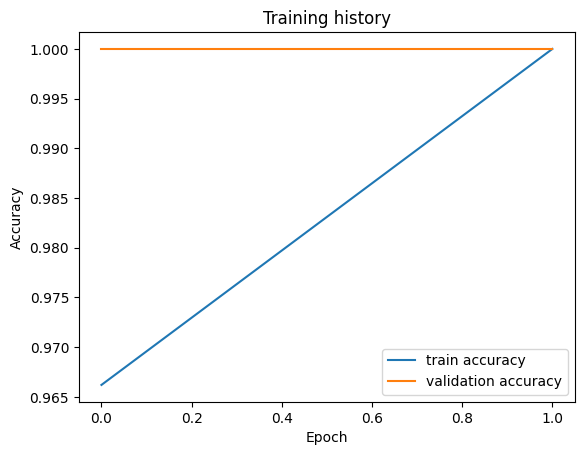

In [55]:
import matplotlib.pyplot as plt

plt.plot(history_cpu['train_acc'], label='train accuracy')
plt.plot(history_cpu['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
# plt.ylim([0, 1]);

In [56]:

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

1.0